In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 프로젝트 1: 직접 고른 이미지로 SRGAN 실험하기

## 프로젝트 1-1

In [ ]:
# 라이브러리 로드
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

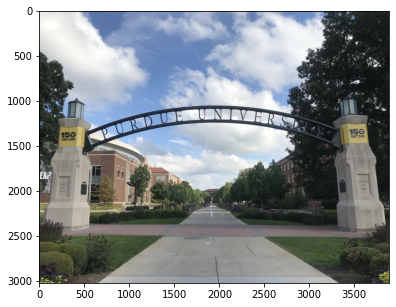

In [ ]:
# 이미지 불러오기
img_path = '/content/gdrive/MyDrive/Colab/Aiffel/Exploration/E16/purdue.JPG'
img_pil = Image.open(img_path)
img = np.array(img_pil)

plt.figure(figsize=(10,5))
plt.imshow(img)

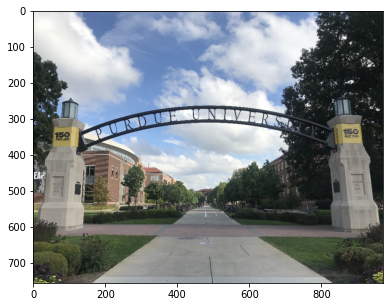

In [ ]:
# 가로 및 세로 픽셀 수를 1/4로 줄임
bicubic_img = cv2.resize(img, dsize=(img.shape[1]//4, img.shape[0]//4), interpolation=cv2.INTER_CUBIC)

plt.figure(figsize=(10,5))
plt.imshow(bicubic_img)

In [ ]:
# 학습된 모델 다운로드
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/srgan_G.h5

--2021-09-10 05:10:27--  https://aiffelstaticprd.blob.core.windows.net/media/documents/srgan_G.h5
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6578112 (6.3M) [application/x-hdf]
Saving to: ‘srgan_G.h5’

srgan_G.h5          100%[===================>]   6.27M  4.24MB/s    in 1.5s    

2021-09-10 05:10:30 (4.24 MB/s) - ‘srgan_G.h5’ saved [6578112/6578112]



In [ ]:
# 학습된 모델 불러오기
model_file = '/content/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file, compile=False)

In [ ]:
# SRGAN을 이용해 고해상도 이미지를 생성
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    print(image.shape)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_img = apply_srgan(bicubic_img)

(1, 755, 972, 3)


In [ ]:
# 픽셀수 줄인 이미지 다시 원래대로 만들
returned_img = cv2.resize(bicubic_img, dsize=(bicubic_img.shape[1]*4, bicubic_img.shape[0]*4), interpolation=cv2.INTER_CUBIC)

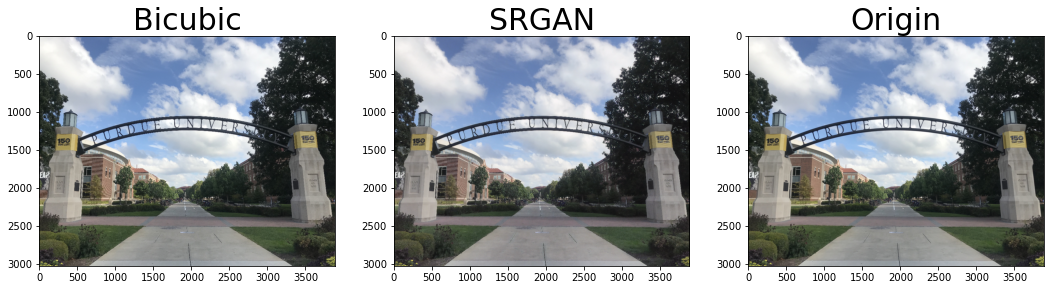

In [ ]:
# 이미지 시각화
images = [returned_img, srgan_img, img]
labels = ['Bicubic', 'SRGAN', 'Origin']
plt.figure(figsize=(18,18))
for i in range(3):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

큰 차이는 없었지만 조금 더 어두운 느낌이 있었다. DIV2K 데이터셋에 있는 데이터들이 어두운 사진이 많아서 이와 같은 현상이 나타난 것 같다.

## 프로젝트 1-2

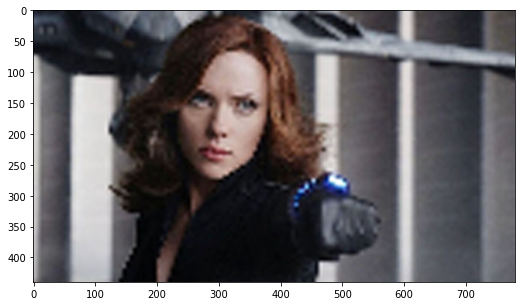

In [ ]:
# 이미지 불러오기
img_path2 = '/content/gdrive/MyDrive/Colab/Aiffel/Exploration/E16/Scarlett.JPG'
img_pil2 = Image.open(img_path2)
img2 = np.array(img_pil2)

plt.figure(figsize=(10,5))
plt.imshow(img2)

In [ ]:
# SRGAN을 이용해 고해상도 이미지를 생성
srgan_img2 = apply_srgan(img2)

(1, 440, 780, 3)


In [ ]:
# 이미지의 픽셀수를 4배로 늘림
bicubic_img2 = cv2.resize(img2, dsize=(img2.shape[1]*4, img2.shape[0]*4), interpolation=cv2.INTER_CUBIC)

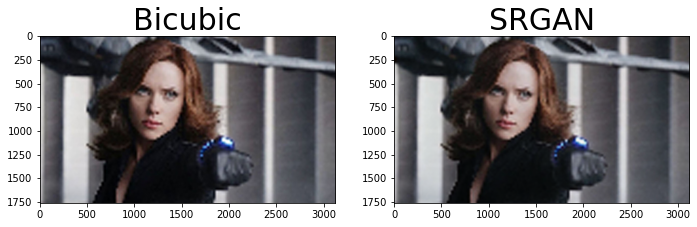

In [ ]:
# 이미지 시각화
images = [bicubic_img2, srgan_img2]
labels = ['Bicubic', 'SRGAN']
plt.figure(figsize=(18,18))
for i in range(2):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

이번에도 두 사진에서 큰 차이를 찾기 어려웠지만, 이번에는 SRGAN에서 인물의 얼굴이 조금 더 밝게 나오게 되었다. 이것은 DIV2K 데이터셋에 있는 데이터들에서 얼굴에 그림자가 있는 경우가 적어서라고 예상된다.

# 프로젝트 2: SRGAN을 이용해 고해상도 gif 생성하기

In [ ]:
# 각 프레임들을 모아 gif 파일을 만드는 라이브러리 설치
!pip install imageio

In [ ]:
# gif 파일 불러오기
gif = cv2.VideoCapture("/content/gdrive/MyDrive/Colab/Aiffel/Exploration/E16/city_night_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


In [ ]:
# 프레임별 Super Resolution 진행하기
frames_bicubic = []
frames_srgan = []

for frame in frames:
  bicubic_frame = cv2.resize(frame, dsize=(frame.shape[1]*4, frame.shape[0]*4), interpolation=cv2.INTER_CUBIC) 
  srgan_frame = apply_srgan(frame)
  frames_bicubic.append(bicubic_frame)
  frames_srgan.append(srgan_frame)

(1, 255, 500, 3)
(1, 255, 500, 3)
(1, 255, 500, 3)
(1, 255, 500, 3)
(1, 255, 500, 3)
(1, 255, 500, 3)
(1, 255, 500, 3)
(1, 255, 500, 3)


In [ ]:
# 프레임을 합쳐 gif 만들기
import imageio

imageio.mimsave("city_night_hr_bicubic.gif", frames_bicubic)
imageio.mimsave("city_night_hr_srgan.gif", frames_srgan)

# gif 링크
원본: https://github.com/dlgur1994/Aiffel/blob/main/Exploration/Data/city_night_lr.gif

bicubic: https://github.com/dlgur1994/Aiffel/blob/main/Exploration/Data/city_night_hr_bicubic.gif

SRGAN: https://github.com/dlgur1994/Aiffel/blob/main/Exploration/Data/city_night_hr_srgan.gif

# 회고
- 이번 프로젝트에서 어려웠던 점
  - 구글 코랩을 사용하기 시작했는데 gif 파일이 보이도록 하는 게 어려웠다.  
- 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  - 논문에서 제안한 모델들을 구성하는 것이 어렵게 느껴졌다.
  - SGRAN 학습에 시간이 오래걸리다 보니 사전 학습된 모델을 다운 받아서 사용했는데, 나중에 스스로 학습해야하는 경우에 어떻게 해야할 지 모르겠다.
- 자기 다짐
  - 다양한 구조들을 이해하고, 논문들을 구현해 봐야겠다.